In [1]:
#!wget https://www.dropbox.com/s/naysvkn55jqxxeo/countries.ttl
#!wget https://www.dropbox.com/s/ymo3pjfqzscsvey/countries.csv

In [1]:
!pip install rdflib
!pip install SPARQLWrapper
!pip install adjustText

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import random
import warnings
warnings.filterwarnings('ignore')
import functools
import itertools
from typing import List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rdflib
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

import sys
sys.path.append('pyRDF2Vec')
sys.path.append('pyRDF2Vec/pyrdf2vec')

from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG
from pyrdf2vec.embedders import Word2Vec
from pyrdf2vec.walkers import (
    AnonymousWalker,
    CommunityWalker,
    HALKWalker,
    NGramWalker,
    RandomWalker,
    WalkletWalker,
    WLWalker,
)
from pyrdf2vec.samplers import (
    ObjPredFreqSampler,
    PredFreqSampler,
    UniformSampler,
    ObjFreqSampler,
    PageRankSampler,
)

import pickle

In [102]:
from pyrdf2vec.graphs import KG
import pandas as pd
# Load graph
view=0
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/home/mayank/VIEW'+str(view)+"/"

nodes = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [103]:
len(nodes), len(edges_df)   

(83987, 1682775)

In [4]:
nodes['name'] = nodes['name'].apply(lambda x: x.replace('<', '').replace('>', ''))
nodes = nodes[(nodes['type'] == 'Disease') | (nodes['type'] == 'Gene') | (nodes['type'] == 'miRNA')]
nodes = nodes[:50]
nodes['type'] = nodes.groupby(['type']).ngroup()
nodes

,name,type
0,http://www.ncbi.nlm.nih.gov/gene/114112,1
1,http://www.ncbi.nlm.nih.gov/gene/60674,1
3,http://www.ncbi.nlm.nih.gov/gene/100527949,1
4,http://www.ncbi.nlm.nih.gov/gene/113523636,1
5,http://purl.obolibrary.org/obo/MONDO_0008693,0
6,http://purl.obolibrary.org/obo/MONDO_0012108,0
8,http://www.ncbi.nlm.nih.gov/gene/111240474,1
11,http://purl.obolibrary.org/obo/MONDO_0011715,0
12,http://www.ncbi.nlm.nih.gov/gene/727851,1
14,http://purl.obolibrary.org/obo/MONDO_0003199,0


In [33]:
edges_df

,subject,predicate,object,type
0,<https://www.mirbase.org/mature/MIMAT0004503>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/51100>,Involved in regulation of
1,<https://www.mirbase.org/mature/MIMAT0015051>,<http://purl.obolibrary.org/obo/RO_0003302>,<http://purl.obolibrary.org/obo/MONDO_0003220>,Causes or contributes to condition
2,<https://www.mirbase.org/mature/MIMAT0021038>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/26057>,Involved in regulation of
3,<https://www.mirbase.org/mature/MIMAT0016887>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/152503>,Involved in regulation of
4,<https://www.mirbase.org/mature/MIMAT0003948>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/166863>,Involved in regulation of
...,...,...,...,...
1682770,<https://www.mirbase.org/mature/MIMAT0000646>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/55274>,Involved in regulation of
1682771,<https://www.mirbase.org/mature/MIMAT0000682>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/3185>,Involved in regulation of
1682772,<https://www.mirbase.org/mature/MIMAT0000090>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/1824>,Involved in regulation of
1682773,<https://www.mirbase.org/mature/MIMAT0028115>,<http://purl.obolibrary.org/obo/RO_0002428>,<http://www.ncbi.nlm.nih.gov/gene/23326>,Involved in regulation of


In [5]:
entities= nodes['name']
sorted(entities)[:5]

['http://purl.obolibrary.org/obo/MONDO_0000307',
 'http://purl.obolibrary.org/obo/MONDO_0000728',
 'http://purl.obolibrary.org/obo/MONDO_0003199',
 'http://purl.obolibrary.org/obo/MONDO_0004415',
 'http://purl.obolibrary.org/obo/MONDO_0004607']

In [6]:
kg = KG('/home/mayank/VIEW0/KG.nt')
kg

KG(location='/home/mayank/VIEW0/KG.nt', skip_predicates=set(), literals=[], fmt=None, mul_req=False, skip_verify=False, cache=TTLCache({}, maxsize=1024, currsize=0), _is_remote=False)

In [7]:
list(kg._entities)[:5]

[Vertex(name='http://purl.obolibrary.org/obo/HP_0002878'),
 Vertex(name='http://purl.obolibrary.org/obo/GO_0003020'),
 Vertex(name='http://purl.obolibrary.org/obo/MONDO_0013529'),
 Vertex(name='http://purl.obolibrary.org/obo/HP_0033011'),
 Vertex(name='http://www.ncbi.nlm.nih.gov/gene/84064')]

In [8]:
type(kg._entities)

set

In [9]:
len(kg._entities)

83987

In [10]:
from pyrdf2vec.graphs.vertex import Vertex

In [11]:
entities_vertex = []
for i in entities:
    entities_vertex.append(Vertex(name=i))
entities_vertex = set(entities_vertex)

In [12]:
[e for e in entities_vertex if e not in kg._entities]

[]

In [13]:
filtered_entities = [e for e in entities_vertex if e not in kg._entities]
not_found = list(set(filtered_entities))
print(f'{not_found} could not be found in the KG! Removing them...')
entities_vertex = set(entities_vertex) - set(filtered_entities)

[] could not be found in the KG! Removing them...


In [14]:
list(entities_vertex)[:5]

[Vertex(name='http://www.ncbi.nlm.nih.gov/gene/80149'),
 Vertex(name='http://purl.obolibrary.org/obo/MONDO_0020247'),
 Vertex(name='http://www.ncbi.nlm.nih.gov/gene/85021'),
 Vertex(name='http://www.ncbi.nlm.nih.gov/gene/4082'),
 Vertex(name='http://www.ncbi.nlm.nih.gov/gene/85459')]

In [15]:
new_entities = []
for i in entities_vertex:
    new_entities.append(i.name)

In [16]:
entities = new_entities

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

def classify(walk_embeddings):
  for task in ['type']:

    # Split our data into train and test (50/50 split)
    data = train_test_split(nodes['name'], nodes[task],
                            stratify=nodes[task], test_size=0.5,
                            random_state=42)
    train_ent, test_ent, y_train, y_test = data

    # Create masks that filter out all entities that are INCLUDED in the KG.
    train_mask = [x in entities for x in train_ent]
    test_mask = [x in entities for x in test_ent]
    y_train = y_train[train_mask]
    y_test = y_test[test_mask]

    # Create our X_train and X_test which consists out of the created embeddings
    X_train = []
    X_test = []
    for entity in train_ent:
      if entity in entities:
        X_train.append(walk_embeddings[entities.index(entity)])
    for entity in test_ent:
      if entity in entities:
        X_test.append(walk_embeddings[entities.index(entity)])
    X_train = np.array(X_train)
    X_test = np.array(X_test)

    # Fit a Random Forest & tune some of its hyper-parameters
    rf = GridSearchCV(RandomForestClassifier(random_state=42),
                      {'n_estimators': [10, 50, 100], 'max_depth': [3, 5, None]},
                      cv=10)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    # Evaluate our model on the test data
    print(task)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    print('Accuracy =', accuracy_score(y_test, preds))
    print(confusion_matrix(y_test, preds))
    print()

In [18]:
from pyrdf2vec.embedders import Word2Vec

In [19]:
transformer = RDF2VecTransformer(walkers=[RandomWalker(2,None)],embedder=Word2Vec(vector_size=500))

In [20]:
walk_embeddings = transformer.fit_transform(kg, entities)

In [21]:
entity_embeddings = {entity: walk_embeddings[0][i] for i, entity in enumerate(entities)}

# Convert to a DataFrame for better visualization (optional)
df = pd.DataFrame(list(entity_embeddings.items()), columns=['Entity', 'Embedding'])
print(df)


                                          Entity  \
0         http://www.ncbi.nlm.nih.gov/gene/80149   
1   http://purl.obolibrary.org/obo/MONDO_0020247   
2         http://www.ncbi.nlm.nih.gov/gene/85021   
3          http://www.ncbi.nlm.nih.gov/gene/4082   
4         http://www.ncbi.nlm.nih.gov/gene/85459   
5           http://www.ncbi.nlm.nih.gov/gene/411   
6   http://purl.obolibrary.org/obo/MONDO_0016467   
7   http://purl.obolibrary.org/obo/MONDO_0859144   
8   http://purl.obolibrary.org/obo/MONDO_0012108   
9   http://purl.obolibrary.org/obo/MONDO_0011715   
10         http://www.ncbi.nlm.nih.gov/gene/3675   
11   https://www.mirbase.org/mature/MIMAT0019891   
12          http://www.ncbi.nlm.nih.gov/gene/523   
13  http://purl.obolibrary.org/obo/MONDO_0019716   
14         http://www.ncbi.nlm.nih.gov/gene/3809   
15   https://www.mirbase.org/mature/MIMAT0019002   
16       http://www.ncbi.nlm.nih.gov/gene/257641   
17  http://purl.obolibrary.org/obo/MONDO_0014958   
18     https

In [22]:
walk_embeddings

([array([ 0.03597258,  0.01945151,  0.01549182,  0.00257491, -0.01805371,
         -0.0109414 , -0.01680957,  0.03175358,  0.00565092,  0.00442535,
         -0.01007455,  0.0039406 ,  0.0082806 ,  0.0001482 , -0.01155342,
         -0.00666099, -0.01013198,  0.01066221,  0.00155766, -0.0247952 ,
         -0.00489836, -0.00149247, -0.0002594 , -0.02070791, -0.00693784,
         -0.00115034, -0.01289003, -0.00534299, -0.01304242, -0.00230779,
         -0.00421725, -0.01535078, -0.00152782, -0.00197143,  0.00504281,
          0.0231802 ,  0.03200308, -0.00146753, -0.021196  , -0.01243985,
         -0.00161564, -0.01285119, -0.02435333,  0.00944774, -0.0167818 ,
         -0.02286441, -0.01738471, -0.00919552,  0.00188786,  0.00052092,
         -0.01619424,  0.00095065, -0.0063585 ,  0.0021453 ,  0.00078659,
         -0.00764248, -0.00864512, -0.01533235, -0.02109892,  0.01257885,
          0.00168449, -0.00531022,  0.00812439, -0.00654843,  0.00389615,
          0.00805017, -0.00211678, -0.

In [23]:
import pandas as pd

# Set the desired number of dimensions
desired_dim = 50

# Create a dictionary to store the reduced embeddings
data = {'Entity': entities}

# Flatten the first 'desired_dim' embedding vectors into separate columns
for i in range(desired_dim):
    data[f'Embedding_{i+1}'] = [embedding[:desired_dim][i] for embedding in walk_embeddings[0]]

# Create the DataFrame
df = pd.DataFrame(data)

# Show the DataFrame
print(df)



                                          Entity  Embedding_1  Embedding_2  \
0         http://www.ncbi.nlm.nih.gov/gene/80149     0.035973     0.019452   
1   http://purl.obolibrary.org/obo/MONDO_0020247     0.085754     0.047038   
2         http://www.ncbi.nlm.nih.gov/gene/85021     0.035622     0.020088   
3          http://www.ncbi.nlm.nih.gov/gene/4082     0.044301     0.022293   
4         http://www.ncbi.nlm.nih.gov/gene/85459     0.004830    -0.000269   
5           http://www.ncbi.nlm.nih.gov/gene/411     0.066509     0.037436   
6   http://purl.obolibrary.org/obo/MONDO_0016467     0.136201     0.073472   
7   http://purl.obolibrary.org/obo/MONDO_0859144     0.017404     0.008291   
8   http://purl.obolibrary.org/obo/MONDO_0012108     0.113124     0.061905   
9   http://purl.obolibrary.org/obo/MONDO_0011715     0.092197     0.050047   
10         http://www.ncbi.nlm.nih.gov/gene/3675     0.064864     0.036842   
11   https://www.mirbase.org/mature/MIMAT0019891     0.134345   

In [25]:
# Save to a CSV file
df.to_csv('rdf2vec_embeddings_view0_MDG.csv', index=False)


In [74]:
df.set_index(df.columns[0], inplace=True)

In [75]:
df.values

array([[ 0.01945151,  0.01549182,  0.00257491, ..., -0.00919552,
         0.00188786,  0.00052092],
       [ 0.04703829,  0.0360297 ,  0.00887435, ..., -0.0255485 ,
         0.00480886,  0.00180528],
       [ 0.02008837,  0.01459646,  0.00616167, ..., -0.00972546,
         0.00097785,  0.00197432],
       ...,
       [ 0.03545979,  0.0317298 ,  0.00740942, ..., -0.01836697,
         0.00531729,  0.00355501],
       [-0.00221225, -0.00056475, -0.00090451, ...,  0.00143359,
         0.00041896,  0.00014289],
       [ 0.00340166,  0.00387109,  0.00089712, ..., -0.00136717,
         0.00187859,  0.00185085]], dtype=float32)

In [26]:
classify(walk_embeddings[0])

type
(25, 500) (25, 500) (25,) (25,)
Accuracy = 0.8
[[ 8  2  0]
 [ 2 11  0]
 [ 1  0  1]]



In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [28]:
nodes.types = nodes['type']

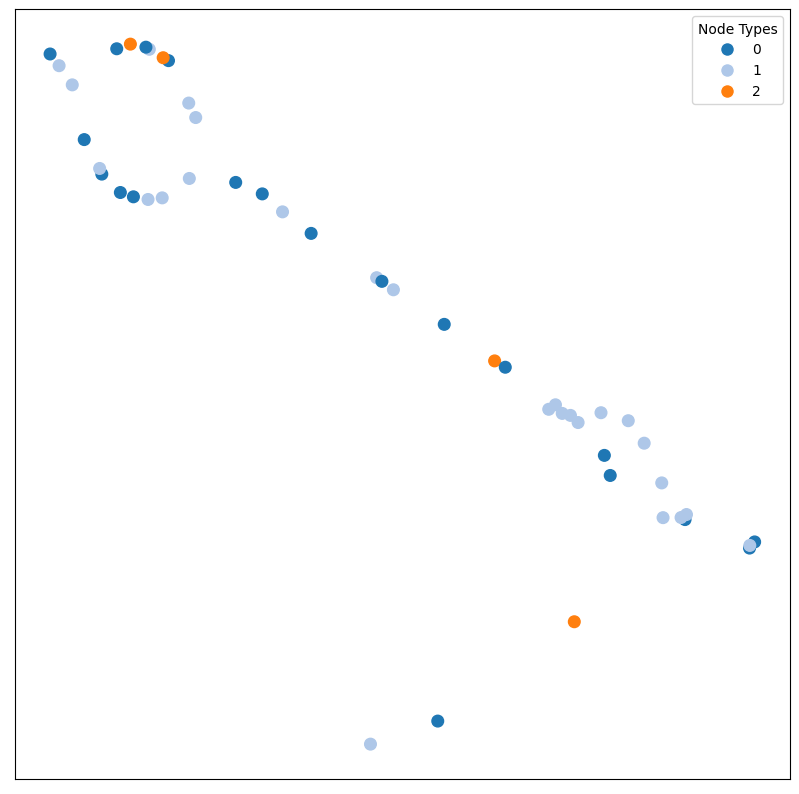

In [48]:
visualize(df.values, nodes.types)

In [30]:
from grape import Graph
from grape import GraphVisualizer
from grape.embedders import TransEEnsmallen
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction


In [104]:
embeddings = pd.read_csv('/home/khushboo/view0_rdf2vec_embeddings.csv', header=None)

In [105]:
embeddings

,0,1
0,node,embedding
1,http://purl.obolibrary.org/obo/MONDO_0000307,[-9.6611190e-04 4.5531307e-04 3.5950586e-03 ...
2,https://www.mirbase.org/mature/MIMAT0019002,[ 5.82144596e-03 1.23027693e-02 4.70880307e-...
3,http://purl.obolibrary.org/obo/MONDO_0013203,[ 4.76050394e-04 -2.25286465e-03 -5.40254870e-...
4,http://www.ncbi.nlm.nih.gov/gene/283298,[ 1.22894405e-03 -6.48009416e-04 3.34417156e-...
5,http://purl.obolibrary.org/obo/MONDO_0016467,[ 6.21707598e-03 1.01178726e-02 4.90424410e-...
6,http://www.ncbi.nlm.nih.gov/gene/727851,[ 5.91993798e-03 1.39991576e-02 5.39542958e-...
7,https://www.mirbase.org/mature/MIMAT0000415,[ 1.51901389e-03 1.64592930e-03 3.45619256e-...
8,http://www.ncbi.nlm.nih.gov/gene/114112,[ 4.08508023e-03 9.34412237e-03 4.04757708e-...
9,http://purl.obolibrary.org/obo/MONDO_0020247,[-1.7719794e-03 6.8294576e-05 2.3776569e-04 ...


In [106]:
df = embeddings.drop([0])

# Reset the index if needed
embeddings = df.reset_index(drop=True)

In [107]:
embeddings

,0,1
0,http://purl.obolibrary.org/obo/MONDO_0000307,[-9.6611190e-04 4.5531307e-04 3.5950586e-03 ...
1,https://www.mirbase.org/mature/MIMAT0019002,[ 5.82144596e-03 1.23027693e-02 4.70880307e-...
2,http://purl.obolibrary.org/obo/MONDO_0013203,[ 4.76050394e-04 -2.25286465e-03 -5.40254870e-...
3,http://www.ncbi.nlm.nih.gov/gene/283298,[ 1.22894405e-03 -6.48009416e-04 3.34417156e-...
4,http://purl.obolibrary.org/obo/MONDO_0016467,[ 6.21707598e-03 1.01178726e-02 4.90424410e-...
5,http://www.ncbi.nlm.nih.gov/gene/727851,[ 5.91993798e-03 1.39991576e-02 5.39542958e-...
6,https://www.mirbase.org/mature/MIMAT0000415,[ 1.51901389e-03 1.64592930e-03 3.45619256e-...
7,http://www.ncbi.nlm.nih.gov/gene/114112,[ 4.08508023e-03 9.34412237e-03 4.04757708e-...
8,http://purl.obolibrary.org/obo/MONDO_0020247,[-1.7719794e-03 6.8294576e-05 2.3776569e-04 ...
9,http://purl.obolibrary.org/obo/MONDO_0008693,[ 6.06923737e-03 1.38516463e-02 5.80634698e-...


In [108]:
embeddings.set_index(embeddings.columns[0], inplace=True)

In [109]:
embeddings.values

array([['[-9.6611190e-04  4.5531307e-04  3.5950586e-03 -4.7344569e-04\n -9.7619640e-03 -4.4308002e-03  3.2361441e-03  6.6707483e-03\n  1.6727442e-03 -5.1688887e-03  6.6453911e-04 -6.0346392e-03\n -1.0377845e-03  2.0058949e-03 -1.0519321e-03 -6.2632402e-03\n -4.3676272e-03 -2.0304115e-03 -1.0719867e-03 -1.6110644e-03\n  1.9909214e-04 -2.1682365e-03  1.5067417e-03  1.9220714e-03\n -3.4155610e-03 -9.2949433e-04  2.7757380e-03 -2.9232320e-03\n -3.1994353e-03 -7.8334403e-04  1.5694192e-03 -1.3552798e-03\n  4.2957016e-03 -1.0702510e-03 -5.2086590e-04  4.6528559e-03\n  5.9422213e-03  8.5225434e-04 -5.6884298e-04 -1.7502618e-03\n -7.5570081e-04 -2.6402499e-03 -1.0053704e-02  2.4116216e-03\n -4.6287067e-03 -3.7935951e-03 -5.7996376e-03  3.6401839e-03\n  1.1649375e-03  3.1500601e-03  1.8269800e-03 -3.8814829e-03\n -1.0299687e-03  4.4908822e-03 -1.2540371e-03 -1.1909545e-03\n  4.1809720e-03 -3.6252397e-03 -2.9992084e-03  1.6562549e-03\n  1.9130557e-03 -7.3632371e-04  2.2746373e-03 -3.7567196e-03\

In [99]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [100]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [110]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=embeddings.values,  # Use simplified embedding features
    smoke_test=False,
    enable_cache=False
)

ValueError: The provided node_features features have shape 50 and do not match the expected number of elements 83987. You are using a graph with name `VIEW0_directed`. We checked this feature against node features, node type features and edge type features and none of them seem to match - it is unclear what you expected this feature to be.